In [1]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

## NLP

ССылка на датасет: https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset

Определить тональность текста (sentiment)

# Проверка данных

In [26]:
questions = pd.read_csv('Tweets.csv')
questions

textID                                               text  \
0      cb774db0d1                I`d have responded, if I were going   
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   Sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  
0                    I`d have responded, if I were going   neutral  
1                                               Sooo SAD  negative  
2                                            bullying me  negative  
3                                         leave me alone  negative  
4                                          Sons of ****,  negative  
...                                                  ...       ...  
27476                                             d lost  negative  
27477                                      , don`t force  negative  
27478                          Yay good for both of you.  positive  
27479                         But it was worth it  ****.  positive  
27480  All this flirting going on - The ATG smiles. Y...   neutral  

[27481 rows x 4 columns]

In [27]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


Удалим пропуски

In [28]:
questions = questions.dropna()

In [29]:
questions.describe()

textID                                  text selected_text  \
count        27480                                 27480         27480   
unique       27480                                 27480         22463   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   

       sentiment  
count      27480  
unique         3  
top      neutral  
freq       11117

In [30]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

<ipython-input-30-8edccd2e4bde>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
<ipython-input-30-8edccd2e4bde>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_field] = df[text_field].str.replace(r"http", "")
<ipython-input-30-8edccd2e4bde>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

textID                                               text  \
0  cb774db0d1                i`d have responded, if i were going   
1  549e992a42      sooo sad i will miss you here in san diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [31]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

Unnamed: 0      textID  \
27475       27476  4eac33d1c0   
27476       27477  4f4c4fc327   
27477       27478  f67aae2310   
27478       27479  ed167662a5   
27479       27480  6f7127d9d7   

                                                    text  \
27475   wish we could come see u on denver  husband l...   
27476   i`ve wondered about rake to.  the client has ...   
27477   yay good for both of you. enjoy the break - y...   
27478                         but it was worth it  ****.   
27479     all this flirting going on - the atg smiles...   

                                           selected_text sentiment  
27475                                             d lost  negative  
27476                                      , don`t force  negative  
27477                          Yay good for both of you.  positive  
27478                         But it was worth it  ****.  positive  
27479  All this flirting going on - The ATG smiles. Y...   neutral

### Анализ данных

Посмотрим на баланс данных

In [32]:
clean_questions.groupby("sentiment").count()

Unnamed: 0  textID   text  selected_text
sentiment                                          
negative         7781    7781   7781           7781
neutral         11117   11117  11117          11117
positive         8582    8582   8582           8582

In [33]:
clean_questions["text"]

0                      i`d have responded, if i were going
1            sooo sad i will miss you here in san diego!!!
2                                my boss is bullying me...
3                           what interview! leave me alone
4         sons of ****, why couldn`t they put them on t...
                               ...                        
27475     wish we could come see u on denver  husband l...
27476     i`ve wondered about rake to.  the client has ...
27477     yay good for both of you. enjoy the break - y...
27478                           but it was worth it  ****.
27479       all this flirting going on - the atg smiles...
Name: text, Length: 27480, dtype: object

Данные выглядят вполне сбалансированными

Нарисуем карту слов.

 i`d have responded, if i were going  sooo sad i will miss you here in san diego!!! my boss is bullying me...  what interview! leave me alone  sons of ****, why couldn`t they put them on the releases we already bought ://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth 2am feedings for the baby are fun when he is all smiles and coos soooo high  both of you  journey!? wow... u just became cooler.  hehe... (is that possible!?)  as much as i love to be hopeful, i reckon the chances are minimal =p i`m never gonna get my cake and stuff i really really like the song love story by taylor swift my sharpie is running dangerously low on ink i want to go to music tonight but i lost my voice. test test from the lg env2 uh oh, i am sunburned  s`ok, trying to plot alternatives as we speak *sigh* i`ve been sick for the past few days  and thus, my hair looks wierd.  if i didnt have a hat on it would look... ://tinyurl.com/mnf4kw is back home now      gonna miss eve

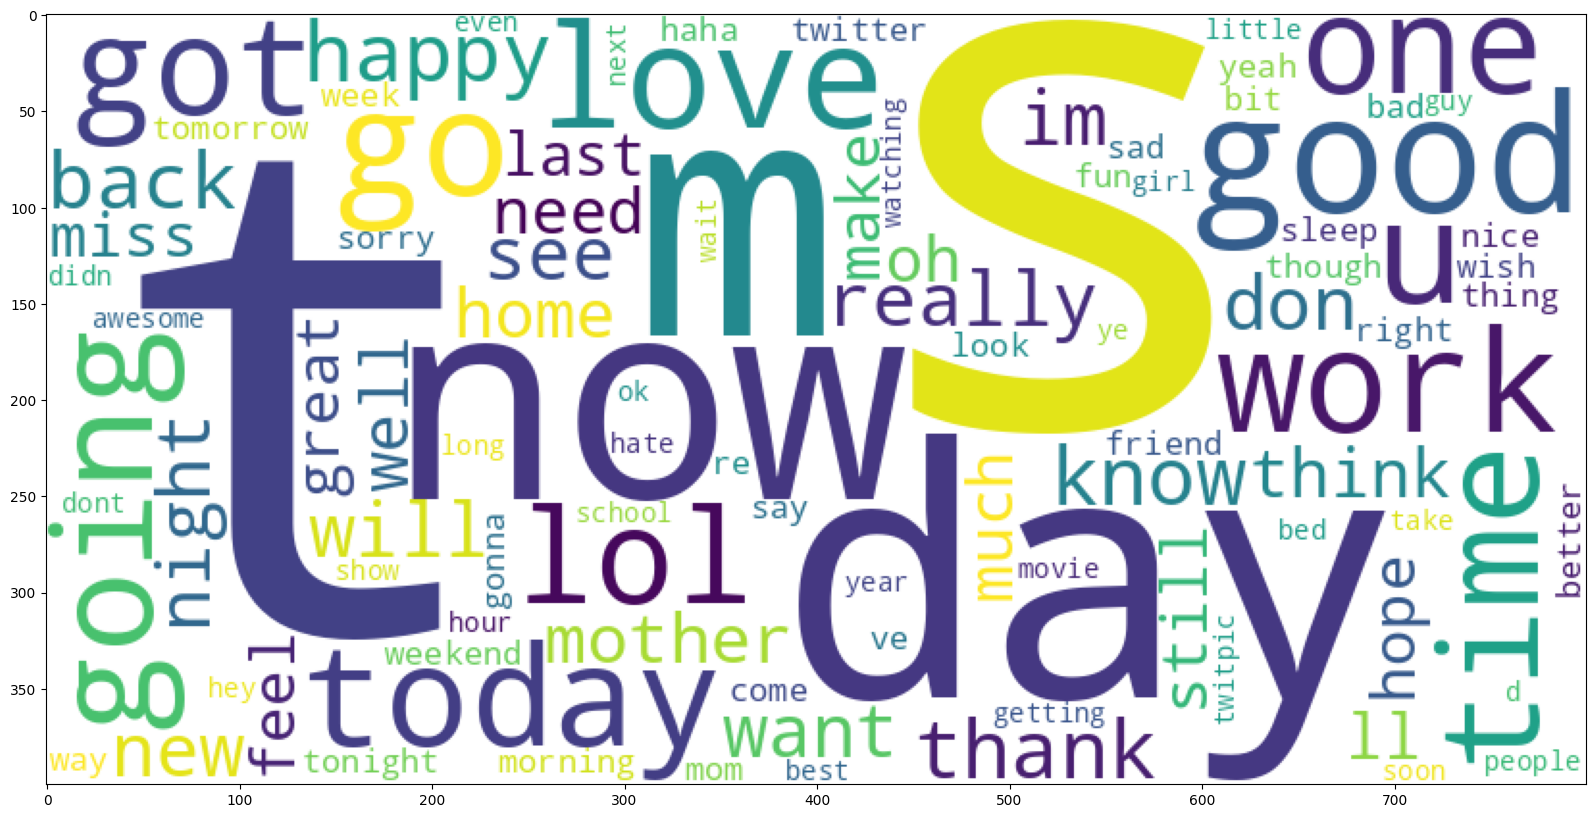

In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

a = " ".join(clean_questions["text"])
print(a)

en_cloud = WordCloud(max_words=100, background_color='white',
                     width=800, height=400,
                     collocations=False).generate(a)
fig = plt.figure(figsize=(20, 10))
plt.imshow(en_cloud);

# Шаг 3.

### Наши данные чисты, теперь их нужно подготовить

Теперь, когда наши входные данные стали более разумными, давайте преобразуем их так, чтобы наша модель могла их понять. Из этого следует:
- Токенизация предложений в список отдельных слов
- Создание тестового сплита трейна
- Еще немного проверяем наши данные, чтобы подтвердить результаты.

In [35]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

Unnamed: 0      textID                                               text  \
0           0  cb774db0d1                i`d have responded, if i were going   
1           1  549e992a42      sooo sad i will miss you here in san diego!!!   
2           2  088c60f138                          my boss is bullying me...   
3           3  9642c003ef                     what interview! leave me alone   
4           4  358bd9e861   sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  \
0  I`d have responded, if I were going   neutral   
1                             Sooo SAD  negative   
2                          bullying me  negative   
3                       leave me alone  negative   
4                        Sons of ****,  negative   

                                              tokens  
0        [i, d, have, responded, if, i, were, going]  
1  [sooo, sad, i, will, miss, you, here, in, san,...  
2                       [my, boss, is, bullying, me]  
3                [what, interview, leave, me, alone]  
4  [sons, of, why, couldn, t, they, put, them, on...

### Анализируем датасет дальше

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from  keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

367556 words total, with a vocabulary size of 26477
Max sentence length is 39


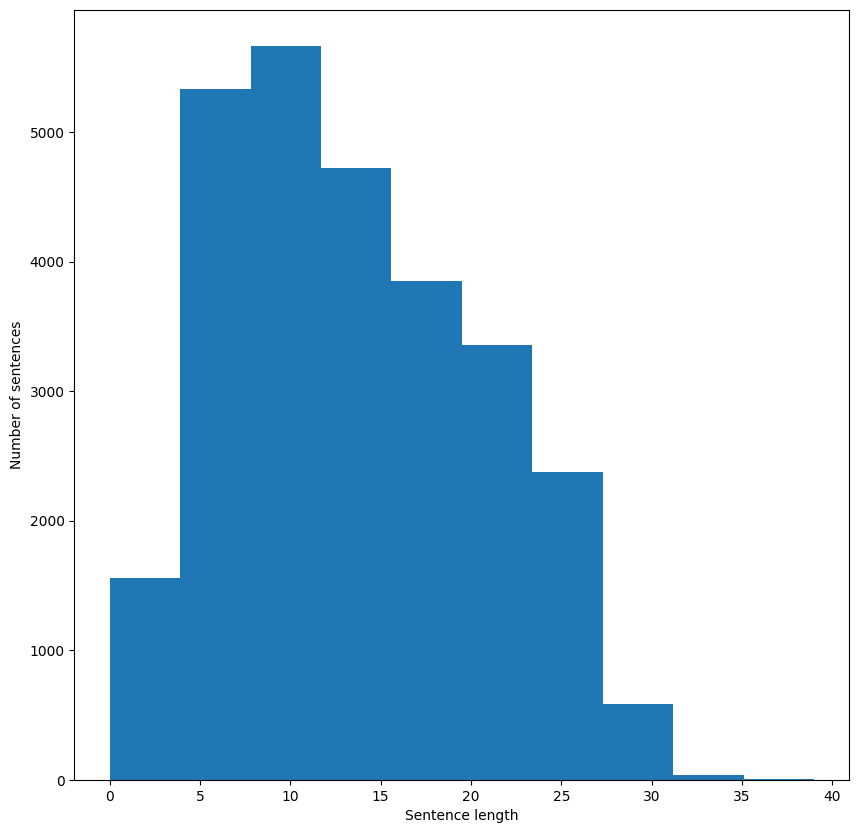

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

## Bag of Words Counts

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer



list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["sentiment"].tolist()

mapping = {
    "positive": 0,
    "negative": 1,
    "neutral": 2
}

list_labels_numeric = [mapping[label] for label in list_labels]

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels_numeric, test_size=0.2,
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Визуализируем векторные представления


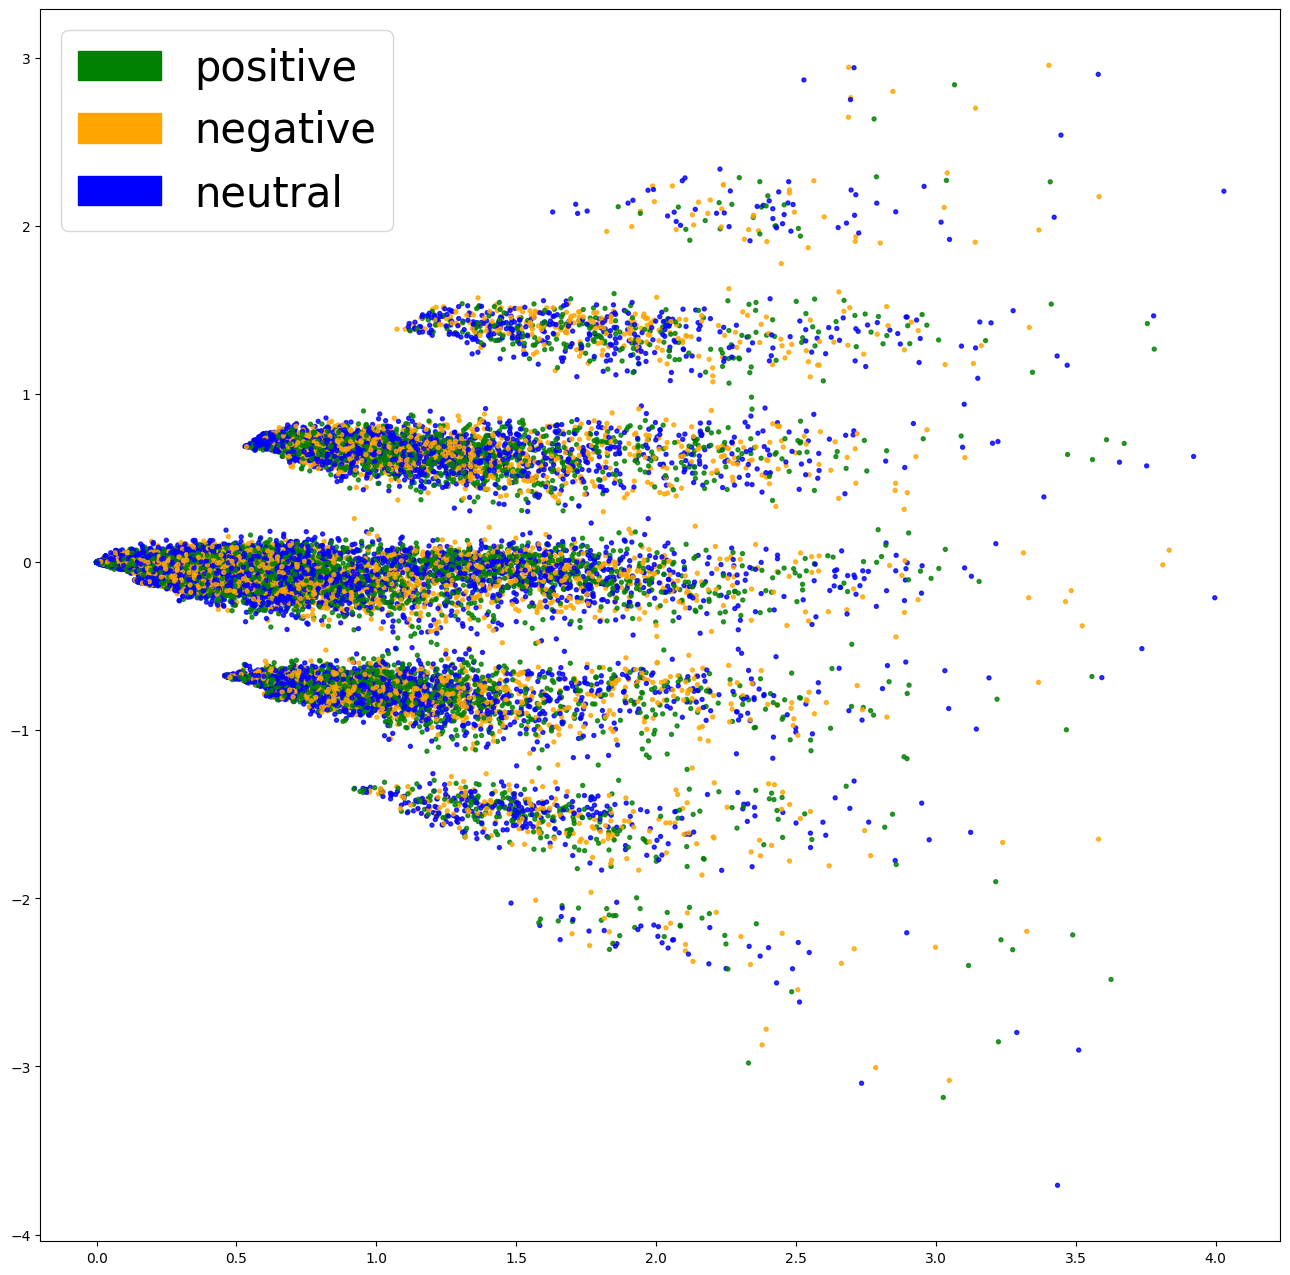

In [39]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        colors = ['green','orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            green_patch = mpatches.Patch(color='green', label='positive')
            orange_patch = mpatches.Patch(color='orange', label='negative')
            blue_patch = mpatches.Patch(color='blue', label='neutral')
            plt.legend(handles=[green_patch, orange_patch, blue_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_counts, y_train)
plt.show()

Что-то не очень....

# Шаг 4. Классификация



In [40]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Метрики!


In [41]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, r2_score, classification_report

def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    r2 = r2_score(y_test, y_predicted)
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1, r2

accuracy, precision, recall, f1, r2 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy, precision, recall, f1,r2))

accuracy = 0.648, precision = 0.648, recall = 0.648, f1 = 0.648, r2 = -0.109


# Шаг 5.

### Инспектирование
Матрица ошибок

In [42]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

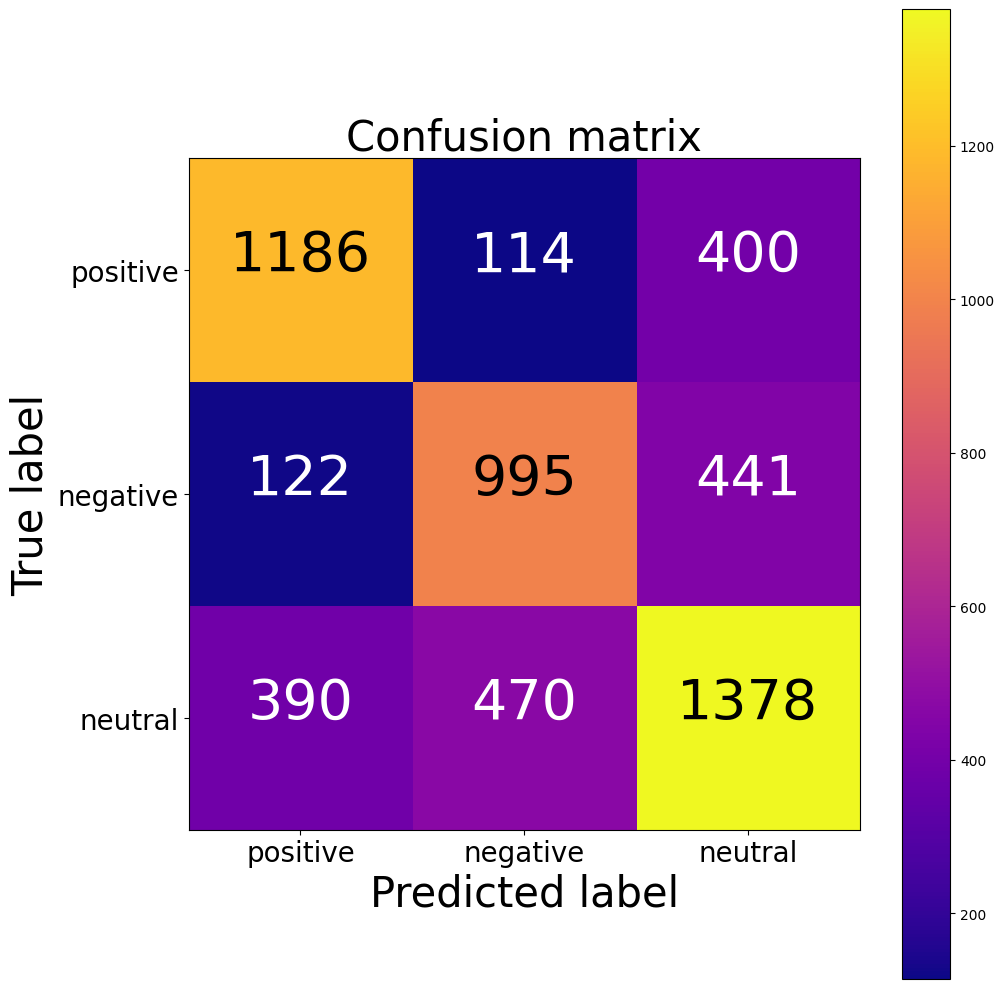

[[1186  114  400]
 [ 122  995  441]
 [ 390  470 1378]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1700
           1       0.63      0.64      0.63      1558
           2       0.62      0.62      0.62      2238

    accuracy                           0.65      5496
   macro avg       0.65      0.65      0.65      5496
weighted avg       0.65      0.65      0.65      5496



In [43]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['positive','negative','neutral'], normalize=False, title='Confusion matrix', cmap="plasma")
plt.show()
print(cm)
print(classification_report(y_test, y_predicted_counts))

**Класс "positive"**: Модель демонстрирует наилучшую производительность для отрицательного класса с F1-мерой около 0.70.

**Классы "negative" и "neutral"**: Модель для положительного и нейтрального классов показывает производительность хуже, что для отрицательного, с F1-мерами около 0.63 и 0.62 соответственно.

Большинство ошибок возникает между парами: **"positive" и "neutral"**, **"negative" и "neutral"**. Скорее всего это происходит из-за того, что "neutral" как переходный класс между "positive" и "negative" затрудняет классификацию.

### Инспектируем дальше

In [44]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

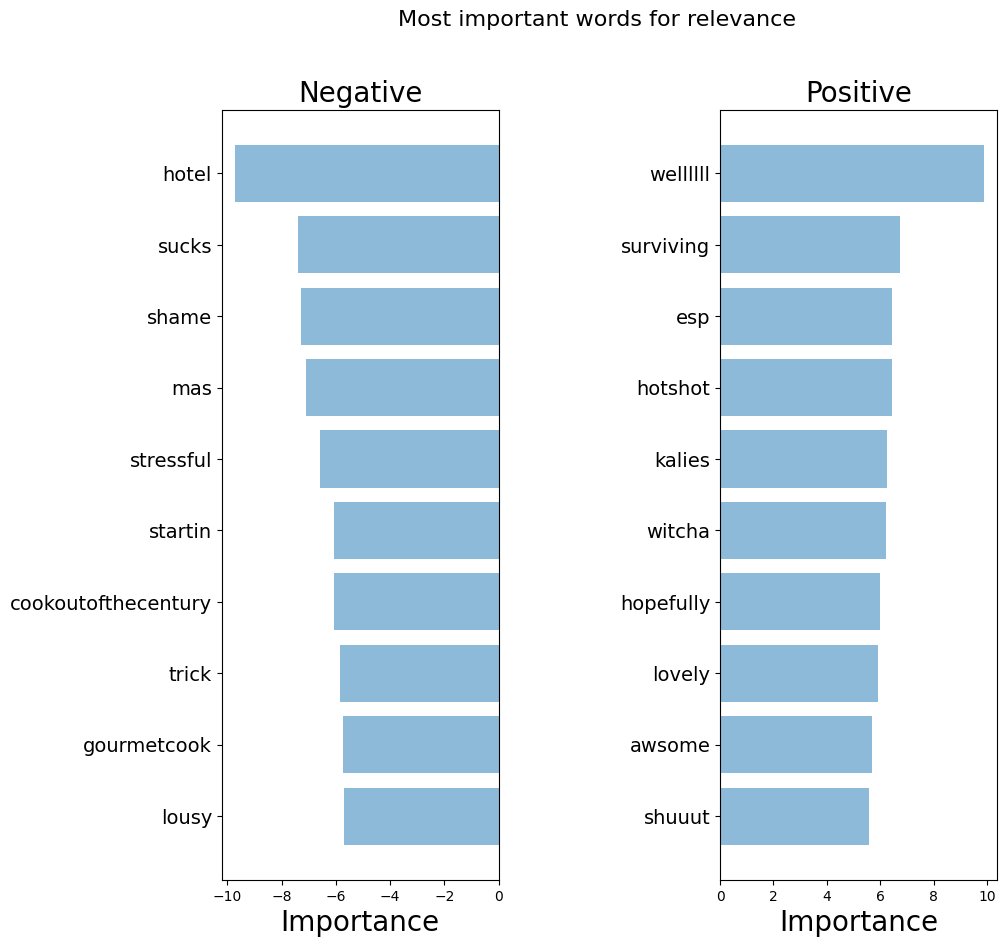

In [45]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Наш классификатор верно нашел несколько паттернов (awsome - "потрясающий", lovely — "прекрасный").

# Шаг 6. Учтите структуру словаря

### TFIDF Bag of Words

In [46]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

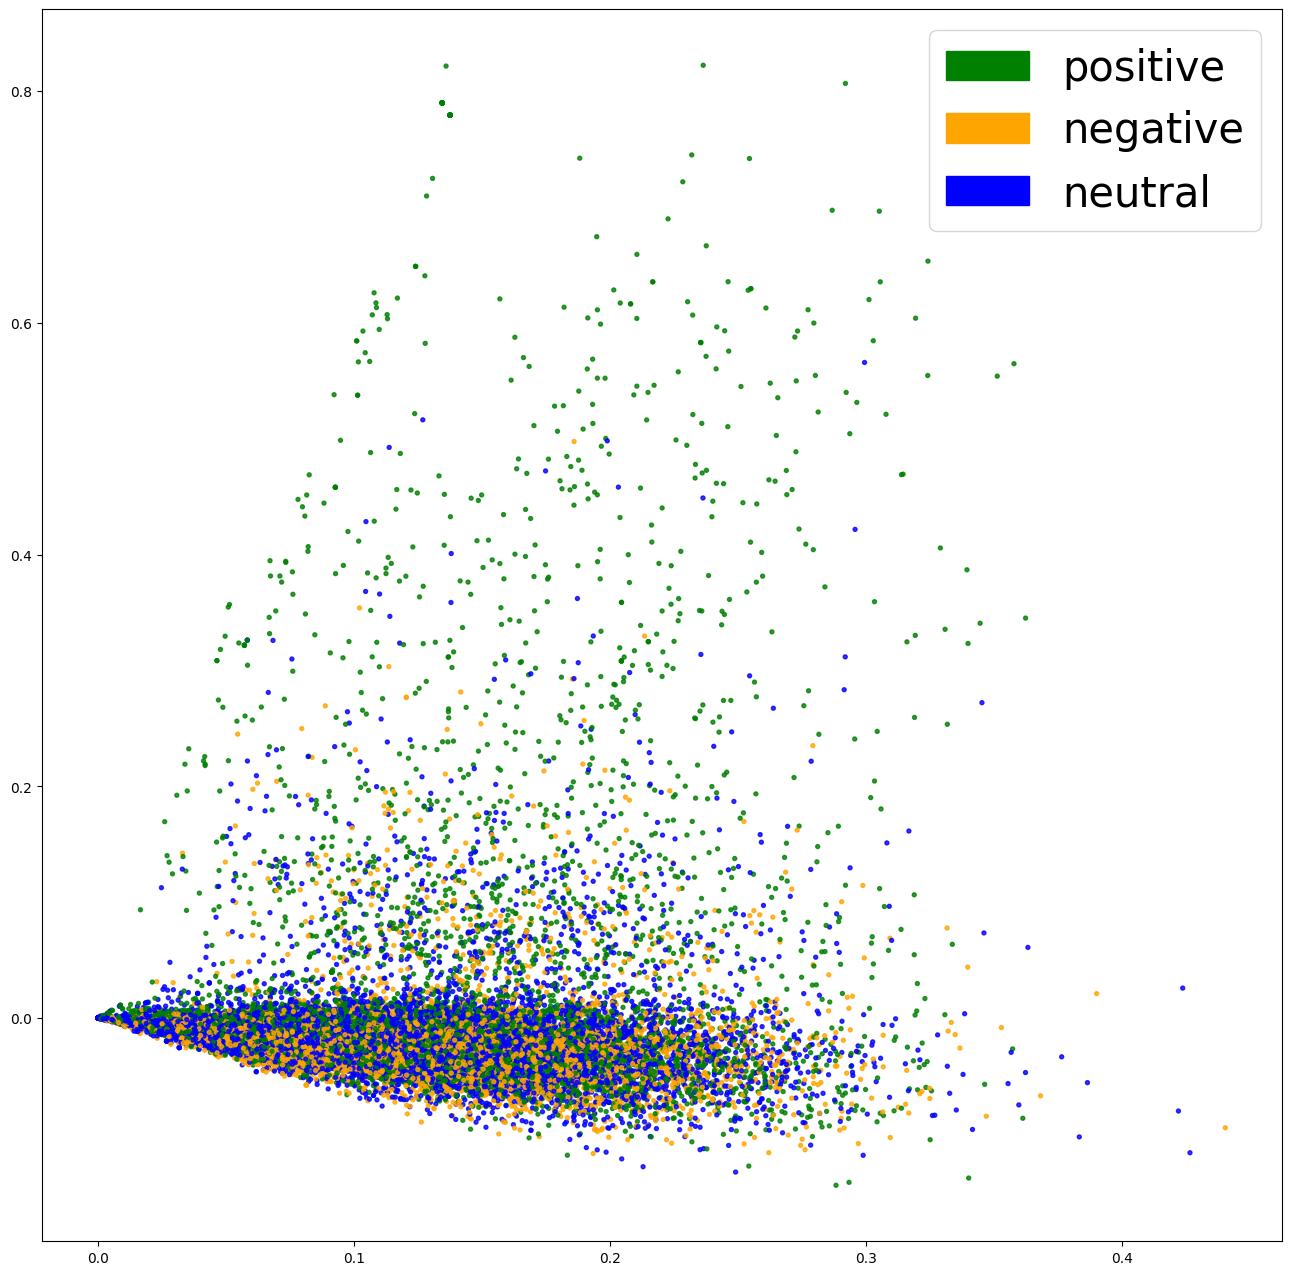

In [47]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [48]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [49]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f"  % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf))


accuracy = 0.658, precision = 0.658, recall = 0.658, f1 = 0.658, r2 = -0.070


Результаты получше

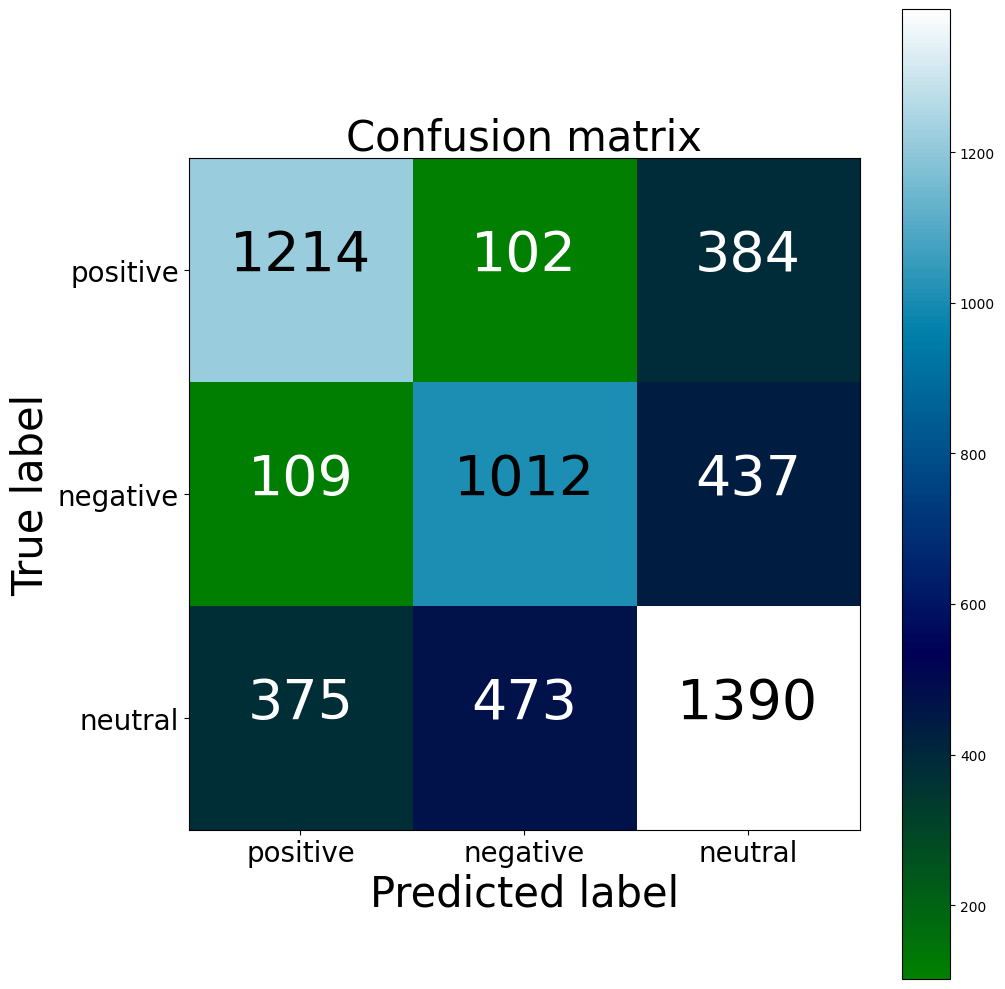

TFIDF confusion matrix
[[1214  102  384]
 [ 109 1012  437]
 [ 375  473 1390]]
BoW confusion matrix
[[1186  114  400]
 [ 122  995  441]
 [ 390  470 1378]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1700
           1       0.63      0.64      0.63      1558
           2       0.62      0.62      0.62      2238

    accuracy                           0.65      5496
   macro avg       0.65      0.65      0.65      5496
weighted avg       0.65      0.65      0.65      5496



In [82]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['positive','negative','neutral'], normalize=False, title='Confusion matrix', cmap="ocean")
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)
print(classification_report(y_test, y_predicted_counts))

Правильно предсказанные значения выросли для всех классов. Ошибочно предсказанные значения уменьшились, кроме neutral, опреленных за negative.

### Посмотрим, какие признаки были важны для предсказания


In [52]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

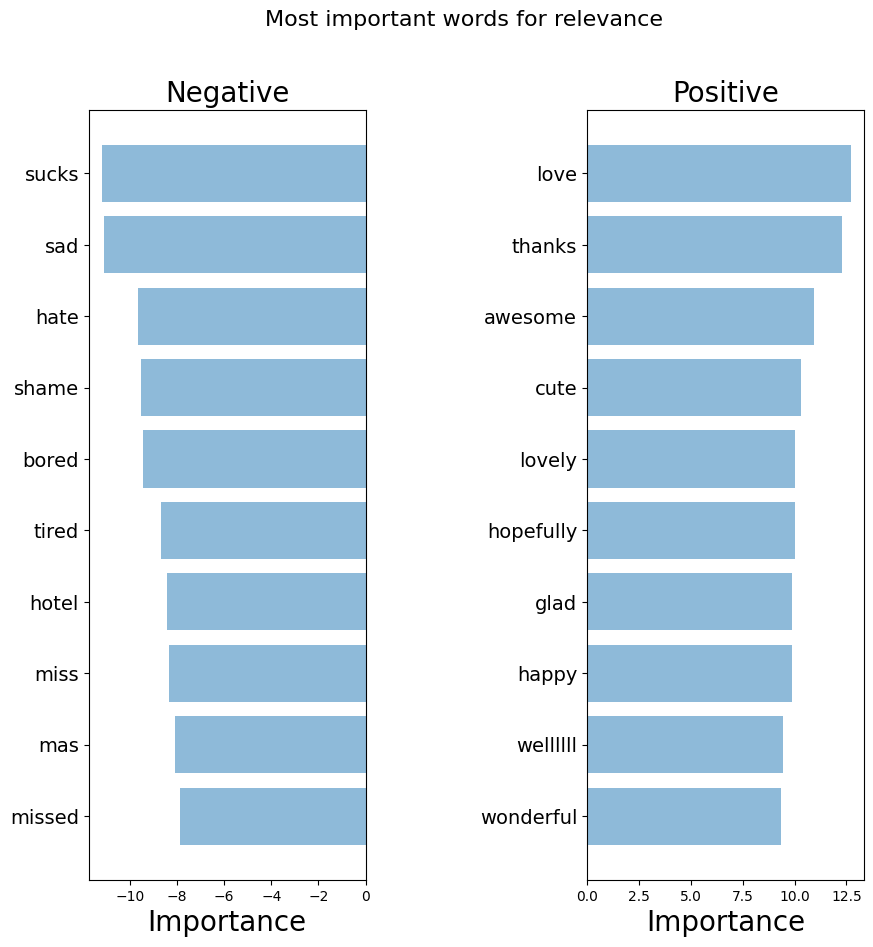

In [53]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Выбранные моделью слова действительно выглядят гораздо более релевантными. Значения метрик увеличились, теперь гораздо больше уверенности в использовании модели в реальной системе, которая будет взаимодействовать с клиентами.

# Шаг 7

### Применение семантики

Word2Vec

In [55]:
!python -m gensim.downloader --download word2vec-google-news-300

2024-12-01 18:27:15,909 : __main__ : INFO : Creating /root/gensim-data
[==================================================] 100.0% 1662.8/1662.8MB downloaded
2024-12-01 18:28:55,809 : __main__ : INFO : word2vec-google-news-300 downloaded
2024-12-01 18:28:55,810 : __main__ : INFO : Data has been installed and data path is /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [56]:
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [57]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [58]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels_numeric,
                                                                                        test_size=0.2, random_state=40)

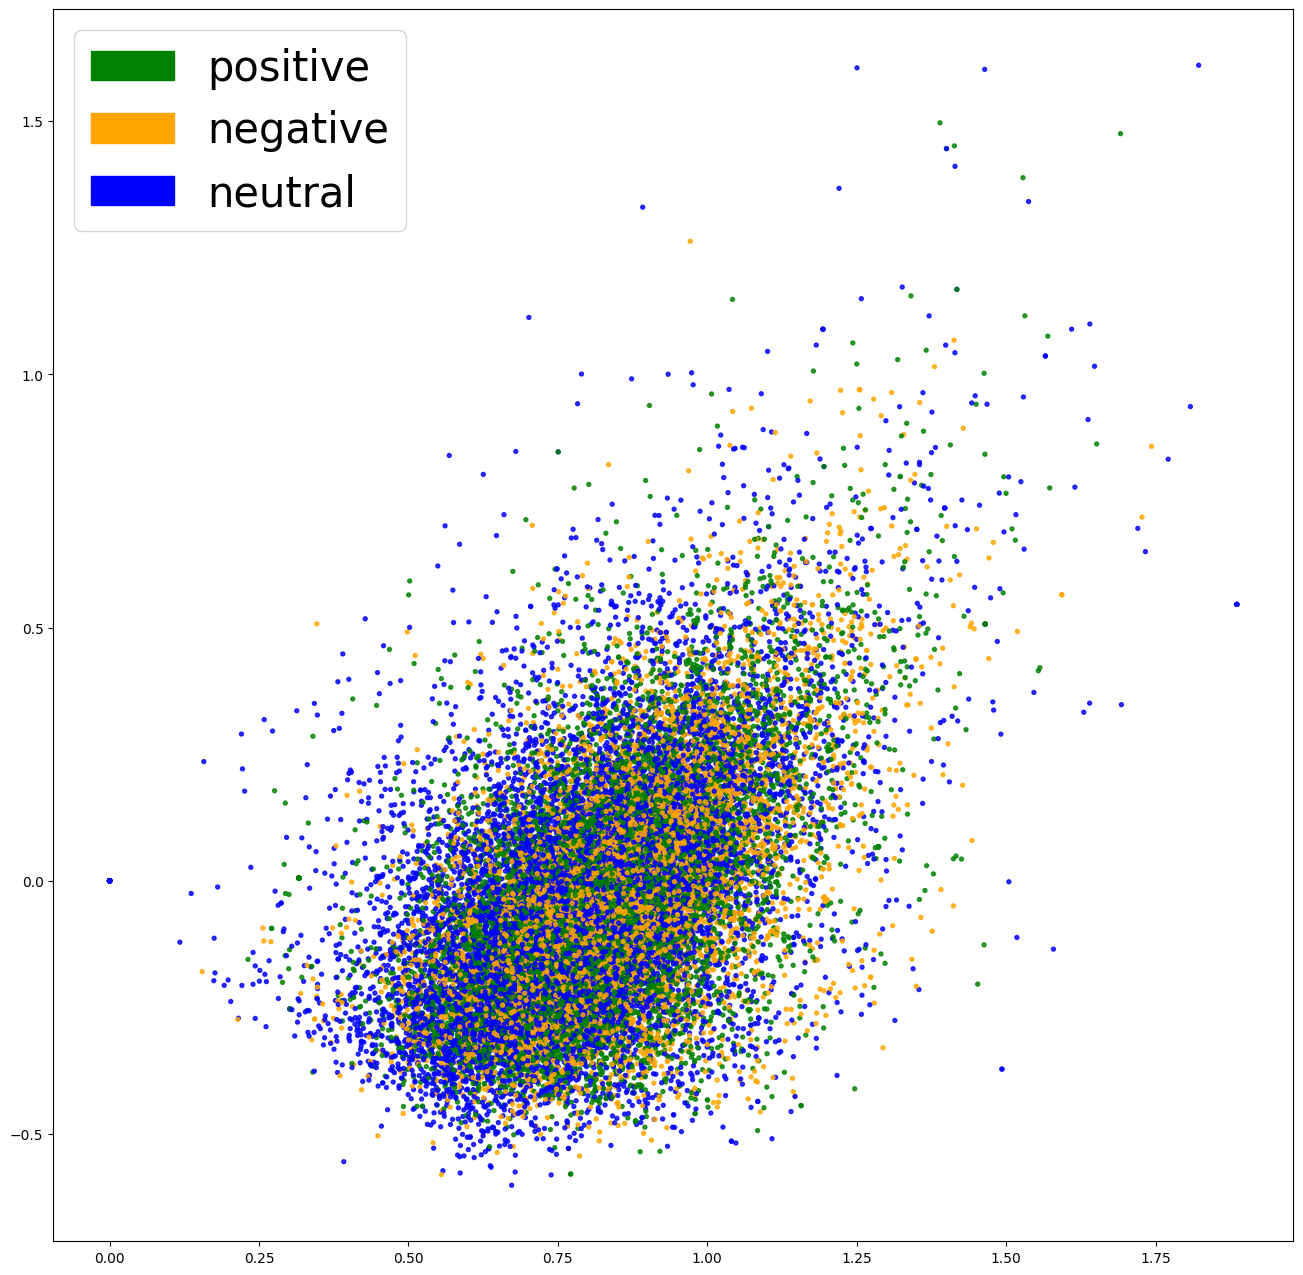

In [59]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(embeddings, list_labels_numeric)
plt.show()

In [60]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [61]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec))

accuracy = 0.666, precision = 0.666, recall = 0.666, f1 = 0.666, r2 = -0.038


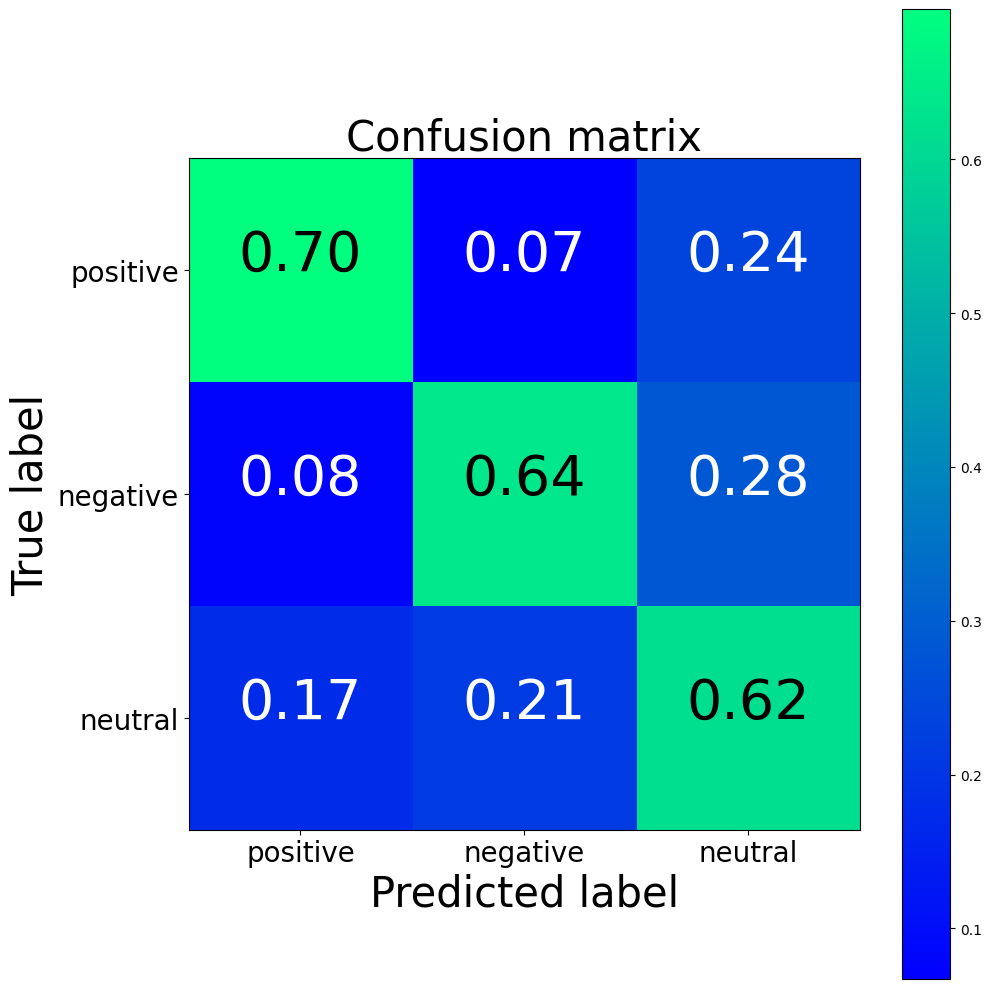

Word2Vec confusion matrix
[[1208  116  376]
 [ 116 1045  397]
 [ 356  476 1406]]
TFIDF confusion matrix
[[1214  102  384]
 [ 109 1012  437]
 [ 375  473 1390]]
BoW confusion matrix
[[1186  114  400]
 [ 122  995  441]
 [ 390  470 1378]]


In [62]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['positive','negative','neutral'], normalize=True, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Правильно предсказанные значения выросли для всех классов, кроме positive (для него уменьшилось всего на 6) в сравнении с TFIDF. В сравнении с BoW правильно предсказанные значения выросли для всех классов. Ошибочно предсказанные значения где-то уменьшились, где-то немного увеличились.

### Further inspection


#### LIME


In [63]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5869680356b92dd56613a7952902e7a99c821cbf3489e420255cc6ac6918a145
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [64]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels_numeric, test_size=0.2,
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [65]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ['positive','negative','neutral']):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [66]:
visualize_one_exp(X_test_data, y_test_data, 100)

Index: 100
True class: negative


In [67]:
visualize_one_exp(X_test_data, y_test_data, 200)

Index: 200
True class: negative


In [68]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()

    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)

    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)

        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]

    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions
label_to_text = {
    0: 'positive',
    1: 'negative',
    2: 'neutral'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

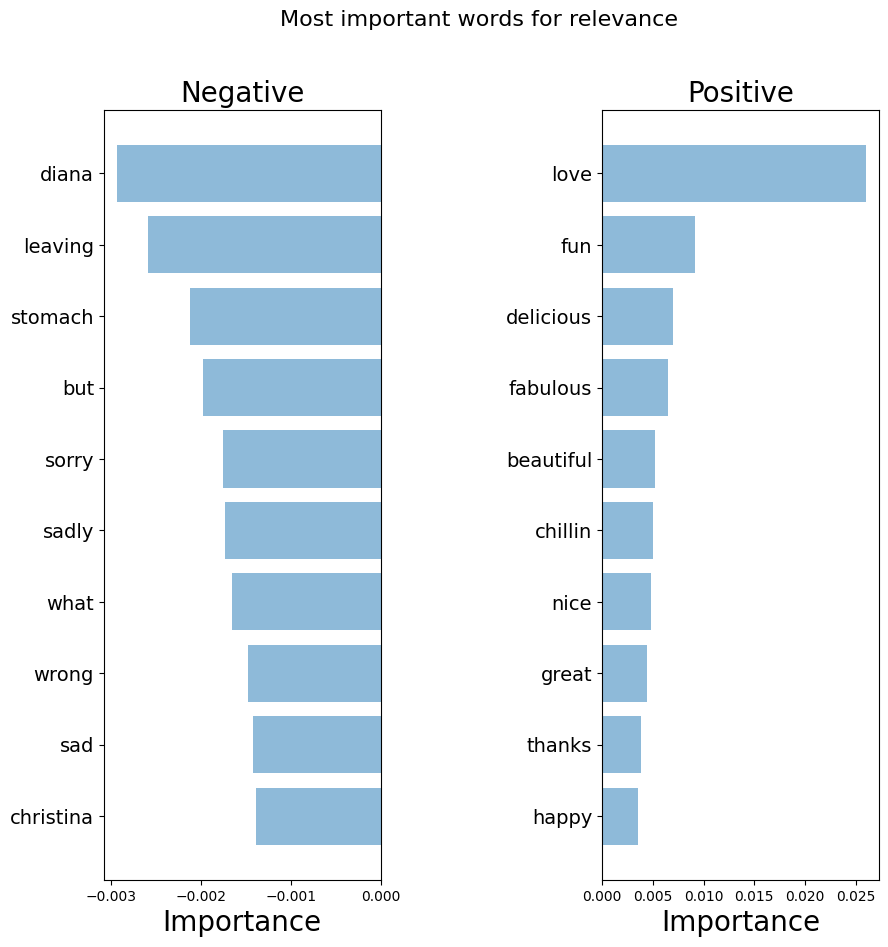

In [70]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['positive']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['positive']['supporters'][:10].tolist()
bottom_words = sorted_contributions['positive']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['positive']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Похоже на то, что модель выбирает высоко релевантные слова и соответственно принимает понятные решения. По сравнению со всеми предыдущими моделями, она выбирает наиболее релевантные слова, поэтому лучше будет отправить в продакшн именно ее.

# Шаг 8. Использование синтаксиса при применении end-to-end подходов

### CNN для NLP


In [72]:
from tensorflow.keras.preprocessing.text  import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["text"].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(list_labels_numeric)

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 26597 unique tokens.
(26598, 300)


Собираем простейшую CNN

In [73]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):

    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

Now let's train our Neural Network

In [74]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM,
                len(list(clean_questions["sentiment"].unique())), False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [75]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Epoch 1/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - acc: 0.4390 - loss: 1.0565 - val_acc: 0.6612 - val_loss: 0.7648
Epoch 2/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 42s 244ms/step - acc: 0.6741 - loss: 0.7381 - val_acc: 0.7060 - val_loss: 0.6931
Epoch 3/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - acc: 0.7270 - loss: 0.6484 - val_acc: 0.7051 - val_loss: 0.6876


In [76]:
y_pred = model.predict(x_val)

172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step


In [77]:
y_pred_cnn = np.argmax(y_pred, axis=1)
y_val_cnn = np.argmax(y_val, axis=1)

In [78]:
y_val_cnn

array([0, 2, 1, ..., 1, 2, 1])

In [79]:
accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn = get_metrics(y_val_cnn, y_pred_cnn)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn))

accuracy = 0.705, precision = 0.710, recall = 0.705, f1 = 0.706, r2 = 0.125


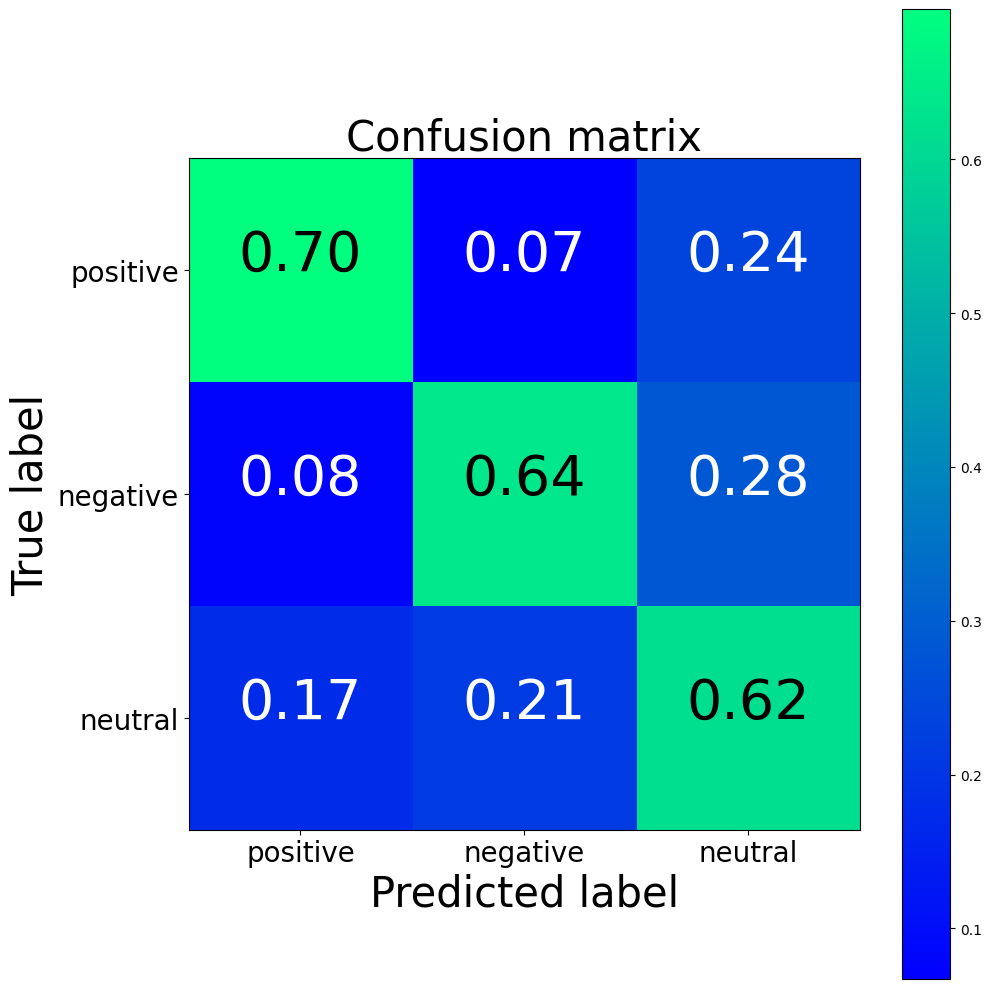

CNN confusion matrix
[[1253  129  363]
 [  73 1121  353]
 [ 237  466 1501]]
Word2Vec confusion matrix
[[1208  116  376]
 [ 116 1045  397]
 [ 356  476 1406]]
TFIDF confusion matrix
[[1214  102  384]
 [ 109 1012  437]
 [ 375  473 1390]]
BoW confusion matrix
[[1186  114  400]
 [ 122  995  441]
 [ 390  470 1378]]


In [80]:
cm_cnn = confusion_matrix(y_val_cnn, y_pred_cnn)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['positive','negative','neutral'], normalize=True, title='Confusion matrix')
plt.show()

print("CNN confusion matrix")
print(cm_cnn)
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Правильно предсказанные значения выросли для всех классов. Ошибочно предсказанные значения уменьшились, кроме positive, опреленных за negative.

Это явно лучшее, что у нас получилось!